In [12]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
#import keras
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.scan_helper_functions import load_dataset, calculate_metrics
from sklearn.preprocessing import MinMaxScaler

In [13]:
print(tf.__version__)

2.4.0


In [15]:
#tf.keras.layers.Normalization(
#    axis=-1, mean=None, variance=None, **kwargs
#)


In [16]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = '/data/project/general/aerosolretriev/aerosol_results_21_08_2022/autoencoder_model'
    
    

In [4]:
version = '1'

In [5]:

datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_15_08_2022/data/data_test.h5'
datafile_training = '/data/project/general/aerosolretriev/aerosol_data/dataset_15_08_2022/data/data_train.h5'


In [7]:
model_dir = directory +'/version1/models_dvar'
model_dir

'/data/project/general/aerosolretriev/aerosol_results_21_08_2022/autoencoder_model/version1/models_dvar'

In [8]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir+'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [9]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_21_08_2022/autoencoder_model/version1/models_dvar/plots/model'

# Load the model and the data

In [10]:
autoencoder = keras.models.load_model(model_dir)
autoencoder

In [11]:
dir(autoencoder)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [12]:
dvar_test = pd.read_hdf(datafile,key = 'dvar')
qoi_test = pd.read_hdf(datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)
dvar_training = pd.read_hdf(datafile_training,key = 'dvar')
qoi_training = pd.read_hdf(datafile_training,key = 'qoi')
dvar_training.reset_index(drop=True, inplace=True)
qoi_training.reset_index(drop=True, inplace=True)


In [13]:
dvar_test

Vtot     RmedianV       GSD         n         k
0         9.782479   740.955994  1.860629  1.509454  1.576845
1         4.953045   447.099789  1.687354  2.622790  0.754203
2         9.853527  2953.110936  2.635387  2.087974  1.787399
3        27.700011   254.587570  1.044152  2.913697  1.101197
4        49.011526   519.446422  2.185569  2.364048  2.055679
...            ...          ...       ...       ...       ...
17995  2902.889066   244.818462  2.048755  1.459021  0.468698
17996     3.793219   204.348275  1.206468  1.562014  1.081841
17997     8.990683   528.078164  1.949690  2.689447  1.873984
17998  2367.063858   780.091790  2.555797  2.806807  0.538075
17999    84.401659   168.632644  2.579873  2.563342  1.104086

[18000 rows x 5 columns]

In [14]:
qoi_test

F11_0      F11_1      F11_2     F11_3     F11_4     F11_5  \
0       4.724405   4.698128   4.626868  4.524194  4.401099  4.265120   
1       3.520831   3.513961   3.493700  3.460988  3.417110  3.363479   
2       6.101202   5.418667   4.791816  4.283079  3.852385  3.477090   
3       4.739477   4.738399   4.735167  4.729780  4.722238  4.712539   
4       6.104491   6.077151   6.009056  5.919210  5.818041  5.711177   
...          ...        ...        ...       ...       ...       ...   
17995   9.326984   9.321643   9.306140  9.281773  9.250076  9.212433   
17996   2.567018   2.566198   2.563739  2.559643  2.553909  2.546539   
17997   4.339135   4.322230   4.275746  4.207695  4.124864  4.032136   
17998  10.347669  10.237037  10.050824  9.860372  9.677098  9.503172   
17999   5.805775   5.798829   5.779319  5.750445  5.715603  5.677180   

          F11_6     F11_7     F11_8     F11_9  ...   PPF_170   PPF_171  \
0      4.121272  3.972914  3.822331  3.671111  ...  0.009200  0.007662   
1      3.301480  3.232396  3.157371  3.077410  ...  0.011450  0.009454   
2      3.143522  2.842779  2.568709  2.316867  ...  0.006427  0.005360   
3      4.700682  4.686667  4.670492  4.652155  ...  0.017385  0.014569   
4      5.601789  5.491736  5.382146  5.273715  ...  0.011993  0.009924   
...         ...       ...       ...       ...  ...       ...       ...   
17995  9.169975  9.123626  9.074131  9.022091  ...  0.018169  0.014794   
17996  2.537537  2.526904  2.514645  2.500762  ...  0.017653  0.014388   
17997  3.932897  3.829500  3.723600  3.616375  ...  0.011119  0.009242   
17998  9.338526  9.182505  9.034339  8.893291  ...  0.010591  0.008676   
17999  5.636472  5.594204  5.550900  5.506951  ...  0.014319  0.011634   

        PPF_172   PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178  \
0      0.006215  0.004875  0.003662  0.002593  0.001687  0.000961  0.000431   
1      0.007603  0.005914  0.004406  0.003097  0.002002  0.001135  0.000507   
2      0.004359  0.003433  0.002591  0.001845  0.001209  0.000695  0.000314   
3      0.011854  0.009307  0.006985  0.004936  0.003204  0.001822  0.000816   
4      0.007999  0.006237  0.004658  0.003282  0.002126  0.001207  0.000540   
...         ...       ...       ...       ...       ...       ...       ...   
17995  0.011745  0.009031  0.006660  0.004640  0.002978  0.001679  0.000747   
17996  0.011432  0.008796  0.006489  0.004523  0.002903  0.001637  0.000729   
17997  0.007479  0.005852  0.004384  0.003097  0.002010  0.001144  0.000513   
17998  0.006927  0.005354  0.003968  0.002776  0.001788  0.001011  0.000451   
17999  0.009218  0.007075  0.005209  0.003624  0.002323  0.001308  0.000582   

        PPF_179  
0      0.000108  
1      0.000127  
2      0.000079  
3      0.000205  
4      0.000136  
...         ...  
17995  0.000187  
17996  0.000182  
17997  0.000129  
17998  0.000113  
17999  0.000146  

[18000 rows x 360 columns]

In [15]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dvar_test_scaled = min_max_scaler.fit_transform(dvar_test)
qoi_test_scaled = min_max_scaler.fit_transform(qoi_test)

In [16]:
qoi_test_scaled = pd.DataFrame(qoi_test_scaled, columns = qoi_test.columns)
qoi_test_scaled

F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      0.357597  0.363436  0.386379  0.392838  0.455949  0.512417  0.482339   
1      0.267399  0.272750  0.292733  0.301531  0.378728  0.446951  0.417523   
2      0.460777  0.418616  0.400011  0.372131  0.412888  0.455200  0.405034   
3      0.358727  0.366520  0.395329  0.410494  0.481152  0.544904  0.528150   
4      0.461024  0.469045  0.500605  0.512641  0.567148  0.617413  0.599395   
...         ...       ...       ...       ...       ...       ...       ...   
17995  0.702524  0.717515  0.773079  0.801415  0.836486  0.871632  0.881510   
17996  0.195918  0.200168  0.215880  0.224124  0.310986  0.387635  0.357123   
17997  0.328725  0.334649  0.357362  0.365658  0.434271  0.495501  0.467445   
17998  0.779016  0.787618  0.834621  0.851105  0.869997  0.892742  0.894836   
17999  0.438638  0.447730  0.481619  0.498148  0.559109  0.614944  0.602137   

          F11_7     F11_8     F11_9  ...   PPF_170   PPF_171   PPF_172  \
0      0.507845  0.504754  0.510086  ...  0.433708  0.399466  0.483826   
1      0.453296  0.456431  0.468218  ...  0.436003  0.401495  0.485299   
2      0.424596  0.413652  0.414583  ...  0.430880  0.396861  0.481856   
3      0.560422  0.566391  0.579270  ...  0.442058  0.407283  0.489812   
4      0.619726  0.618107  0.623104  ...  0.436557  0.402026  0.485720   
...         ...       ...       ...  ...       ...       ...       ...   
17995  0.887263  0.886407  0.887443  ...  0.442858  0.407538  0.489696   
17996  0.401327  0.409723  0.427552  ...  0.442331  0.407079  0.489363   
17997  0.497281  0.497579  0.506226  ...  0.435666  0.401254  0.485167   
17998  0.891600  0.883515  0.878360  ...  0.435127  0.400614  0.484582   
17999  0.627274  0.630371  0.639552  ...  0.438930  0.403962  0.487013   

        PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  
0      0.608091  0.688284  0.738598  0.694086  0.617440  0.625964  0.808709  
1      0.609073  0.689031  0.739265  0.694687  0.617761  0.626188  0.808805  
2      0.606728  0.687210  0.737610  0.693176  0.616945  0.625617  0.808560  
3      0.612281  0.691617  0.741697  0.696981  0.619034  0.627101  0.809202  
4      0.609379  0.689284  0.739510  0.694924  0.617896  0.626286  0.808848  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.612020  0.691292  0.741306  0.696549  0.618769  0.626898  0.809110  
17996  0.611798  0.691121  0.741150  0.696407  0.618691  0.626843  0.809086  
17997  0.609015  0.689009  0.739265  0.694704  0.617778  0.626204  0.808813  
17998  0.608544  0.688591  0.738841  0.694279  0.617531  0.626021  0.808732  
17999  0.610171  0.689836  0.739962  0.695300  0.618083  0.626409  0.808898  

[18000 rows x 360 columns]

In [17]:
dvar_test_scaled = pd.DataFrame(dvar_test_scaled, columns = dvar_test.columns)
dvar_test_scaled

Vtot  RmedianV       GSD         n         k
0      0.001757  0.130820  0.430088  0.107462  0.716772
1      0.000791  0.070843  0.343393  0.774167  0.342799
2      0.001771  0.582329  0.817722  0.453900  0.812489
3      0.005343  0.031550  0.021581  0.948372  0.500542
4      0.009607  0.085609  0.592665  0.619223  0.934449
...         ...       ...       ...       ...       ...
17995  0.580680  0.029556  0.524213  0.077260  0.213008
17996  0.000559  0.021296  0.102792  0.138936  0.491743
17997  0.001599  0.087371  0.474648  0.814083  0.851851
17998  0.473459  0.138808  0.777901  0.884363  0.244547
17999  0.016689  0.014006  0.789947  0.738567  0.501856

[18000 rows x 5 columns]

In [18]:

test_data = [dvar_test_scaled.values,qoi_test_scaled.values]
#test_data = [dvar_training.values,qoi_training.values]
#qoi_test = qoi_training
#dvar_test = dvar_training

In [19]:
test_data[1]

array([[0.35759745, 0.36343602, 0.38637935, ..., 0.61743967, 0.62596381,
        0.80870887],
       [0.26739915, 0.27274982, 0.2927332 , ..., 0.61776135, 0.62618823,
        0.80880479],
       [0.4607774 , 0.41861644, 0.40001083, ..., 0.61694535, 0.62561667,
        0.80856021],
       ...,
       [0.32872456, 0.33464889, 0.35736228, ..., 0.6177777 , 0.62620379,
        0.80881256],
       [0.77901623, 0.78761795, 0.83462075, ..., 0.61753111, 0.62602135,
        0.80873177],
       [0.43863752, 0.44773011, 0.48161915, ..., 0.61808281, 0.62640926,
        0.80889843]])

# Predict

In [20]:
dvar1_pred_test = autoencoder.predict(test_data)
dvar2_pred_test = autoencoder.decoder(test_data[1])
qoi_pred_test = autoencoder.encoder(test_data[0])

In [21]:
qoi_pred_test = np.array(qoi_pred_test)
dvar2_pred_test = np.array(dvar2_pred_test)
dvar1_pred_test = pd.DataFrame(data=dvar1_pred_test, columns=dvar_test.columns)
qoi_pred_test = pd.DataFrame(data=qoi_pred_test, columns=qoi_test.columns)
dvar2_pred_test = pd.DataFrame(data=dvar2_pred_test, columns=dvar_test.columns)


In [22]:
dvar2_pred_test

Vtot  RmedianV       GSD         n         k
0      0.002504  0.167104  0.432130  0.512108  0.403905
1     -0.000153  0.069326  0.551242  0.589606  0.024125
2      0.002100  0.551889  0.764558  0.341780  0.595997
3      0.008423  0.039776  0.562723  0.471734  0.097764
4      0.015733  0.073118  0.508312  0.585913  0.316733
...         ...       ...       ...       ...       ...
17995  0.375806  0.014906  0.691366  0.407590  0.120531
17996 -0.001237  0.029923  0.457554  0.641592  0.143242
17997  0.001584  0.077618  0.490940  0.611031  0.208117
17998  0.412870  0.066755  0.606246  0.636016  0.032455
17999  0.016483 -0.005448  0.618260  0.544804  0.165459

[18000 rows x 5 columns]

# Calculate metrics

In [23]:
#qoi_test = pd.DataFrame(data = qoi_test,columns=qoi_test.columns)
#dvar_test = pd.DataFrame(data = dvar_test,columns=dvar_test.columns)

In [24]:
dvar_test= dvar_test_scaled
qoi_test = qoi_test_scaled

In [25]:
dvar1_pred_test

Vtot  RmedianV       GSD         n         k
0      0.001153  0.132061  0.455626  0.111130  0.714962
1      0.000352  0.071703  0.368396  0.771880  0.343097
2      0.001468  0.594997  0.836390  0.451370  0.816060
3      0.005317  0.034023  0.044737  0.945511  0.498749
4      0.007562  0.088073  0.614041  0.619852  0.932233
...         ...       ...       ...       ...       ...
17995  0.587144  0.029162  0.560267  0.078828  0.206891
17996 -0.000943  0.021641  0.123245  0.137822  0.492327
17997  0.000509  0.088441  0.496358  0.815579  0.850711
17998  0.471004  0.142775  0.806243  0.882279  0.241170
17999  0.017350  0.013690  0.815137  0.738663  0.500394

[18000 rows x 5 columns]

In [26]:
qoi_test

F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      0.357597  0.363436  0.386379  0.392838  0.455949  0.512417  0.482339   
1      0.267399  0.272750  0.292733  0.301531  0.378728  0.446951  0.417523   
2      0.460777  0.418616  0.400011  0.372131  0.412888  0.455200  0.405034   
3      0.358727  0.366520  0.395329  0.410494  0.481152  0.544904  0.528150   
4      0.461024  0.469045  0.500605  0.512641  0.567148  0.617413  0.599395   
...         ...       ...       ...       ...       ...       ...       ...   
17995  0.702524  0.717515  0.773079  0.801415  0.836486  0.871632  0.881510   
17996  0.195918  0.200168  0.215880  0.224124  0.310986  0.387635  0.357123   
17997  0.328725  0.334649  0.357362  0.365658  0.434271  0.495501  0.467445   
17998  0.779016  0.787618  0.834621  0.851105  0.869997  0.892742  0.894836   
17999  0.438638  0.447730  0.481619  0.498148  0.559109  0.614944  0.602137   

          F11_7     F11_8     F11_9  ...   PPF_170   PPF_171   PPF_172  \
0      0.507845  0.504754  0.510086  ...  0.433708  0.399466  0.483826   
1      0.453296  0.456431  0.468218  ...  0.436003  0.401495  0.485299   
2      0.424596  0.413652  0.414583  ...  0.430880  0.396861  0.481856   
3      0.560422  0.566391  0.579270  ...  0.442058  0.407283  0.489812   
4      0.619726  0.618107  0.623104  ...  0.436557  0.402026  0.485720   
...         ...       ...       ...  ...       ...       ...       ...   
17995  0.887263  0.886407  0.887443  ...  0.442858  0.407538  0.489696   
17996  0.401327  0.409723  0.427552  ...  0.442331  0.407079  0.489363   
17997  0.497281  0.497579  0.506226  ...  0.435666  0.401254  0.485167   
17998  0.891600  0.883515  0.878360  ...  0.435127  0.400614  0.484582   
17999  0.627274  0.630371  0.639552  ...  0.438930  0.403962  0.487013   

        PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  
0      0.608091  0.688284  0.738598  0.694086  0.617440  0.625964  0.808709  
1      0.609073  0.689031  0.739265  0.694687  0.617761  0.626188  0.808805  
2      0.606728  0.687210  0.737610  0.693176  0.616945  0.625617  0.808560  
3      0.612281  0.691617  0.741697  0.696981  0.619034  0.627101  0.809202  
4      0.609379  0.689284  0.739510  0.694924  0.617896  0.626286  0.808848  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.612020  0.691292  0.741306  0.696549  0.618769  0.626898  0.809110  
17996  0.611798  0.691121  0.741150  0.696407  0.618691  0.626843  0.809086  
17997  0.609015  0.689009  0.739265  0.694704  0.617778  0.626204  0.808813  
17998  0.608544  0.688591  0.738841  0.694279  0.617531  0.626021  0.808732  
17999  0.610171  0.689836  0.739962  0.695300  0.618083  0.626409  0.808898  

[18000 rows x 360 columns]

In [27]:
res_qoi = qoi_test - qoi_pred_test
print(res_qoi)

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles_qoi = res_qoi.abs().quantile(q)
quantiles_qoi.to_csv(f'{plot_dir}/qoi_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

          F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      0.020984  0.020838  0.036892  0.028791 -0.022333  0.040745  0.024092   
1      0.018921  0.020779  0.026647  0.026158 -0.028283  0.050374  0.030217   
2      0.015953  0.019852  0.033014  0.029775 -0.025290  0.040170  0.018787   
3     -0.011472 -0.007697  0.018656  0.012410 -0.025915  0.040012  0.030168   
4      0.014198  0.013464  0.032320  0.028600 -0.012245  0.045070  0.037603   
...         ...       ...       ...       ...       ...       ...       ...   
17995 -0.020167 -0.017068  0.002056  0.018213  0.015451  0.043396  0.055322   
17996  0.011583  0.011526  0.025188  0.023966 -0.035961  0.047061  0.026812   
17997  0.023134  0.025950  0.048061  0.037428 -0.016552  0.049236  0.029717   
17998 -0.009140  0.002139  0.025366  0.032551  0.019418  0.055939  0.067100   
17999 -0.010993 -0.000581  0.011673  0.014843 -0.019502  0.041619  0.034122   

          F11_7     F11_8     F11_9  ...   PPF_170 

In [28]:
res_dvar1 = dvar_test - dvar1_pred_test
quantiles_dvar1 = res_dvar1.abs().quantile(q)
quantiles_dvar1.to_csv(f'{plot_dir}/dvar1_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [29]:
F11_columns = [x for x in qoi_test.columns if "F11" in x]
F11_columns

['F11_0',
 'F11_1',
 'F11_2',
 'F11_3',
 'F11_4',
 'F11_5',
 'F11_6',
 'F11_7',
 'F11_8',
 'F11_9',
 'F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_86',
 'F11_87',
 'F11_88',
 'F11_89',
 'F11_90',
 'F11_91'

In [30]:
metric_qoi = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_qoi = metric_qoi.call(qoi_test.values, qoi_pred_test.values).numpy()
r2_adj_qoi = pd.Series(data=r2_adj_qoi, index=qoi_test.columns)
r2_adj_qoi = np.round(r2_adj_qoi, decimals=2)
r2_adj_qoi = pd.DataFrame(r2_adj_qoi).T

In [31]:
r2_adj_qoi

F11_0  F11_1  F11_2  F11_3  F11_4  F11_5  F11_6  F11_7  F11_8  F11_9  ...  \
0   0.99   0.99   0.98   0.98   0.97   0.94   0.96   0.95   0.94   0.97  ...   

   PPF_170  PPF_171  PPF_172  PPF_173  PPF_174  PPF_175  PPF_176  PPF_177  \
0   -10.37    -0.52   -35.97  -327.23  -629.34  -893.92  -156.74    -10.4   

   PPF_178  PPF_179  
0  -194.75 -2410.14  

[1 rows x 360 columns]

In [32]:
print(min(r2_adj_qoi.min()))
print(max(r2_adj_qoi.max()))

-inf
1.0


In [33]:
print(min(r2_adj_qoi[F11_columns].min()))
print(max(r2_adj_qoi[F11_columns].max()))

0.94
1.0


In [34]:
metric_dvar1 = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_dvar1 = metric_dvar1.call(dvar_test.values, dvar1_pred_test.values).numpy()
r2_adj_dvar1 = pd.Series(data=r2_adj_dvar1, index=dvar_test.columns)
r2_adj_dvar1 = np.round(r2_adj_dvar1, decimals=2)
r2_adj_dvar1 = pd.DataFrame(r2_adj_dvar1).T

In [35]:
r2_adj_dvar1

Vtot  RmedianV   GSD    n    k
0   1.0       1.0  0.99  1.0  1.0

In [36]:
print(min(r2_adj_dvar1.min()))
print(max(r2_adj_dvar1.max()))

0.99
1.0


In [37]:
metric_dvar2 = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_dvar2 = metric_dvar1.call(dvar_test.values, dvar2_pred_test.values).numpy()
r2_adj_dvar2 = pd.Series(data=r2_adj_dvar2, index=dvar_test.columns)
r2_adj_dvar2 = np.round(r2_adj_dvar2, decimals=2)
r2_adj_dvar2 = pd.DataFrame(r2_adj_dvar2).T
r2_adj_dvar2

Vtot  RmedianV   GSD     n     k
0  0.87      0.85  0.43  0.23 -0.22

In [38]:
rel_error_qoi = (qoi_pred_test - qoi_test) / qoi_test * 100.
rel_error_qoi = pd.DataFrame(rel_error_qoi, columns=qoi_test.columns).abs()
rel_error_qoi.reset_index(drop=True, inplace=True)
rel_error_qoi

F11_0     F11_1      F11_2      F11_3      F11_4      F11_5  \
0      5.868018  5.733499   9.548127   7.328973   4.898054   7.951576   
1      7.076078  7.618501   9.102903   8.674914   7.467784  11.270474   
2      3.462130  4.742403   8.253279   8.001264   6.125251   8.824756   
3      3.197980  2.099896   4.718989   3.023300   5.386071   7.342919   
4      3.079730  2.870544   6.456143   5.579022   2.159024   7.299885   
...         ...       ...        ...        ...        ...        ...   
17995  2.870720  2.378706   0.265890   2.272651   1.847148   4.978740   
17996  5.911977  5.758228  11.667674  10.693257  11.563417  12.140513   
17997  7.037453  7.754481  13.448851  10.235806   3.811365   9.936683   
17998  1.173222  0.271623   3.039241   3.824594   2.232014   6.265976   
17999  2.506093  0.129830   2.423636   2.979544   3.487999   6.767976   

          F11_6      F11_7      F11_8     F11_9  ...    PPF_170   PPF_171  \
0      4.994775   6.970816   8.617690  5.530908  ...  14.503430  3.525266   
1      7.237268   9.330847  12.177264  8.259630  ...  13.885057  3.376334   
2      4.638429   6.740375   9.393435  5.187043  ...  15.288123  4.855016   
3      5.712052   6.052568   7.413128  4.074790  ...  13.143488  1.247028   
4      6.273450   6.830820   7.288590  4.882609  ...  14.272454  3.733301   
...         ...        ...        ...       ...  ...        ...       ...   
17995  6.275862   5.006716   5.418592  3.900874  ...  14.179810  2.783811   
17996  7.507799  11.019475  14.622009  9.922137  ...  11.852148  1.329306   
17997  6.357356   8.439186   9.800290  6.420053  ...  14.137494  3.067863   
17998  7.498572   6.284098   6.077325  4.534209  ...  14.839530  5.023376   
17999  5.666869   6.349493   7.130512  4.718760  ...  14.014302  4.560628   

         PPF_172    PPF_173    PPF_174    PPF_175    PPF_176   PPF_177  \
0      19.344083  37.437894  42.446055  52.008348  26.474522  5.519235   
1      19.729121  37.659318  42.535757  51.480490  26.572607  5.371996   
2      19.210292  37.162596  42.403132  51.732758  26.330901  5.678980   
3      19.548415  37.570275  42.791877  50.261611  26.915583  5.302939   
4      19.395838  37.098519  42.411357  52.265478  26.412692  5.602847   
...          ...        ...        ...        ...        ...       ...   
17995  19.032025  36.792410  42.283661  50.800039  26.747830  5.427460   
17996  20.657990  38.041016  43.054250  51.472013  26.962414  4.903830   
17997  19.586273  37.274192  42.630017  51.762936  26.515162  5.345852   
17998  19.130144  36.986155  42.018780  51.787560  26.139425  5.947332   
17999  19.577109  36.953509  42.212307  51.996216  26.317287  5.687850   

         PPF_178    PPF_179  
0      24.913354  56.403299  
1      24.899556  56.542529  
2      24.874220  56.655180  
3      25.060641  56.500012  
4      24.761408  56.565366  
...          ...        ...  
17995  24.927435  56.539925  
17996  25.256278  56.616760  
17997  25.014311  56.663952  
17998  24.482784  56.422397  
17999  24.761648  56.506658  

[18000 rows x 360 columns]

In [39]:
rel_error_dvar1 = (dvar1_pred_test - dvar_test) / dvar_test * 100.
rel_error_dvar1 = pd.DataFrame(rel_error_dvar1, columns=dvar_test.columns).abs()
rel_error_dvar1.reset_index(drop=True, inplace=True)
rel_error_dvar1

Vtot  RmedianV         GSD         n         k
0       34.364013  0.948625    5.937786  3.413292  0.252462
1       55.528403  1.214923    7.281244  0.295403  0.086822
2       17.147473  2.175381    2.282918  0.557233  0.439512
3        0.484426  7.839387  107.303179  0.301715  0.358149
4       21.286668  2.878142    3.606886  0.101559  0.237164
...           ...       ...         ...       ...       ...
17995    1.113194  1.333472    6.877796  2.029052  2.871863
17996  268.837976  1.619106   19.896876  0.802404  0.118674
17997   68.133910  1.225261    4.574069  0.183675  0.133760
17998    0.518586  2.858148    3.643475  0.235577  1.381065
17999    3.962234  2.257452    3.188887  0.012992  0.291185

[18000 rows x 5 columns]

In [40]:
rel_error_dvar2 = (dvar2_pred_test - dvar_test) / dvar_test * 100.
rel_error_dvar2 = pd.DataFrame(rel_error_dvar2, columns=dvar_test.columns).abs()
rel_error_dvar2.reset_index(drop=True, inplace=True)
rel_error_dvar2

Vtot    RmedianV          GSD           n          k
0       42.474009   27.736176     0.474854  376.548726  43.649454
1      119.319174    2.140441    60.527926   23.839962  92.962269
2       18.524597    5.227264     6.501456   24.701439  26.645523
3       57.658053   26.071021  2507.532849   50.258577  80.468314
4       63.768507   14.590394    14.232779    5.379347  66.104881
...           ...         ...          ...         ...        ...
17995   35.281847   49.565627    31.886408  427.552783  43.415048
17996  321.455058   40.510511   345.125356  361.788263  70.870535
17997    0.933810   11.161797     3.432502   24.942408  75.568813
17998   12.797117   51.908226    22.066360   28.082024  86.728411
17999    1.234146  138.897507    21.733985   26.235059  67.030660

[18000 rows x 5 columns]

In [41]:
rel_error_table_qoi = np.round(rel_error_qoi.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_qoi

/psi/home/boiger_r/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


F11_0  F11_1  F11_2  F11_3  F11_4  F11_5  F11_6  F11_7  F11_8  F11_9  \
50%   2.39   2.28   4.44   4.38   3.38   6.40   6.00   5.97   6.46   4.29   
75%   5.10   4.57   6.62   6.07   7.68   7.85   7.03   7.13   8.80   5.65   
90%   9.23   8.83  11.19  10.33  15.98  10.99   7.96   9.66  12.59   8.37   
95%  12.76  11.56  14.35  12.66  25.40  12.22   9.59  10.88  14.00   9.59   
99%  25.47  23.74  23.30  20.00  39.41  15.12  17.92  15.69  18.41  13.28   

     ...  PPF_170  PPF_171  PPF_172  PPF_173  PPF_174  PPF_175  PPF_176  \
50%  ...    14.45     4.19    19.42    37.24    42.43    51.59    26.43   
75%  ...    14.97     4.92    19.74    37.56    42.68    51.93    26.63   
90%  ...    15.43     5.68    20.27    37.94    43.02    52.23    26.91   
95%  ...    15.84     6.77    21.09    38.28    43.28    52.49    27.16   
99%  ...    22.30    14.11    25.06    40.31    44.72    53.58    28.94   

     PPF_177  PPF_178  PPF_179  
50%     5.60    24.81    56.54  
75%     5.78    24.95    56.65  
90%     5.95    25.12    56.76  
95%     6.14    25.26    56.83  
99%     7.03    26.00    56.99  

[5 rows x 360 columns]

In [42]:
rel_error_table_qoi.min(axis = 1)

50%    0.53
75%    1.09
90%    2.49
95%    4.26
99%    7.03
dtype: float64

In [43]:
rel_error_table_qoi.max(axis = 1)

50%    211.47
75%    306.55
90%    404.19
95%    473.18
99%    632.43
dtype: float64

In [44]:
rel_error_table_dvar1 = np.round(rel_error_dvar1.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_dvar1

Vtot  RmedianV     GSD      n      k
50%     6.11      2.96    4.65   0.47   0.66
75%    54.41      4.68    8.83   1.11   1.45
90%   312.36     13.81   20.87   2.92   4.48
95%  1010.47     37.45   40.98   5.90   7.49
99%  7082.42    252.08  197.98  33.72  50.21

In [45]:
rel_error_table_dvar1.min(axis = 1)

50%     0.47
75%     1.11
90%     2.92
95%     5.90
99%    33.72
dtype: float64

In [46]:
rel_error_table_dvar1.max(axis = 1)

50%       6.11
75%      54.41
90%     312.36
95%    1010.47
99%    7082.42
dtype: float64

In [47]:
rel_error_table_dvar2 = np.round(rel_error_dvar2.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_dvar2

Vtot  RmedianV      GSD        n       k
50%     42.93     26.55    26.61    34.43   60.64
75%     94.76     50.72    65.30    98.58   75.64
90%    532.31    161.91   272.06   358.24  119.90
95%   1991.81    432.56   641.22   754.74  205.88
99%  16976.33   3077.26  3858.81  4283.54  953.41

In [48]:
rel_error_table_dvar2.min(axis = 1)

50%     26.55
75%     50.72
90%    119.90
95%    205.88
99%    953.41
dtype: float64

In [49]:
rel_error_table_dvar2.max(axis = 1)

50%       60.64
75%       98.58
90%      532.31
95%     1991.81
99%    16976.33
dtype: float64

# Save $\bar{R}^2$

In [50]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [51]:
r2_adj_T_qoi = r2_adj_qoi.T
r2_adj_T_qoi=r2_adj_T_qoi.rename(columns={0: "r2_adj"})
r2_adj_T_qoi

r2_adj
F11_0       0.99
F11_1       0.99
F11_2       0.98
F11_3       0.98
F11_4       0.97
...          ...
PPF_175  -893.92
PPF_176  -156.74
PPF_177   -10.40
PPF_178  -194.75
PPF_179 -2410.14

[360 rows x 1 columns]

In [52]:
r2_adj_T_qoi.min()

r2_adj   -inf
dtype: float64

In [53]:
r2_adj_T_dvar1 = r2_adj_dvar1.T
r2_adj_T_dvar1=r2_adj_T_dvar1.rename(columns={0: "r2_adj"})
r2_adj_T_dvar1

r2_adj
Vtot        1.00
RmedianV    1.00
GSD         0.99
n           1.00
k           1.00

# Plot

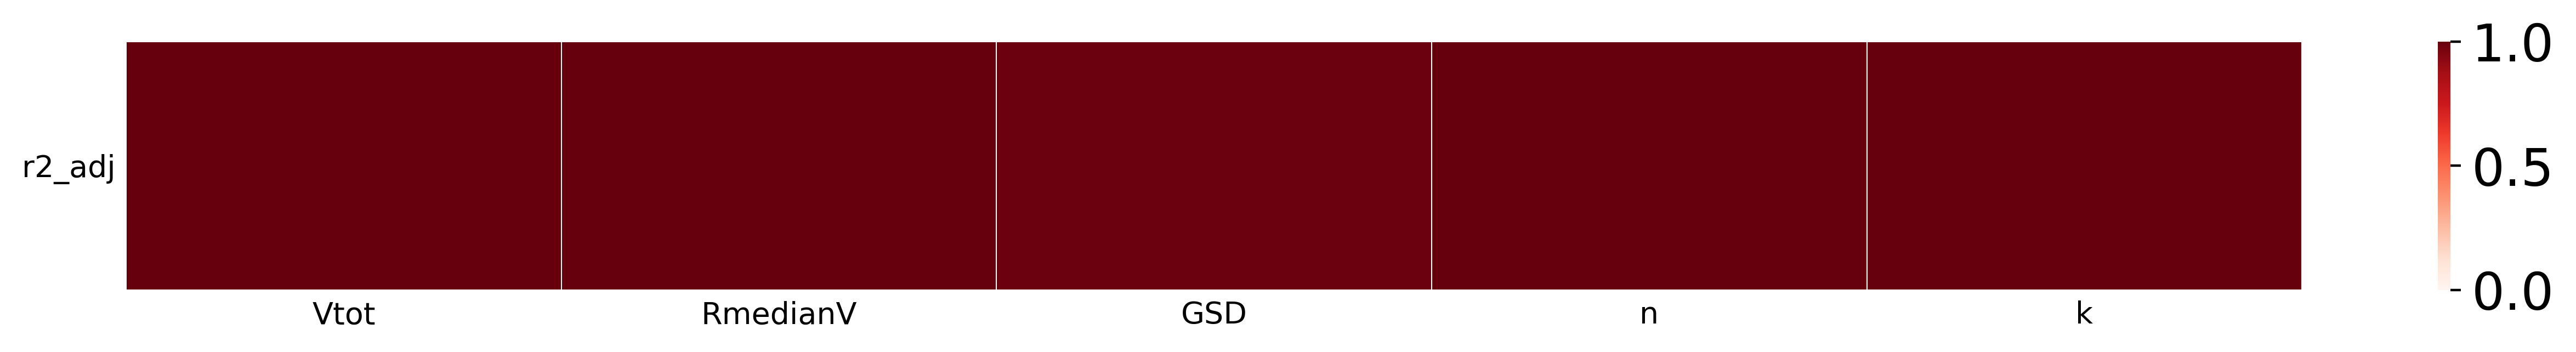

In [54]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_dvar1, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_dvar1.jpg')


In [55]:
r2_adj_T_dvar1

r2_adj
Vtot        1.00
RmedianV    1.00
GSD         0.99
n           1.00
k           1.00

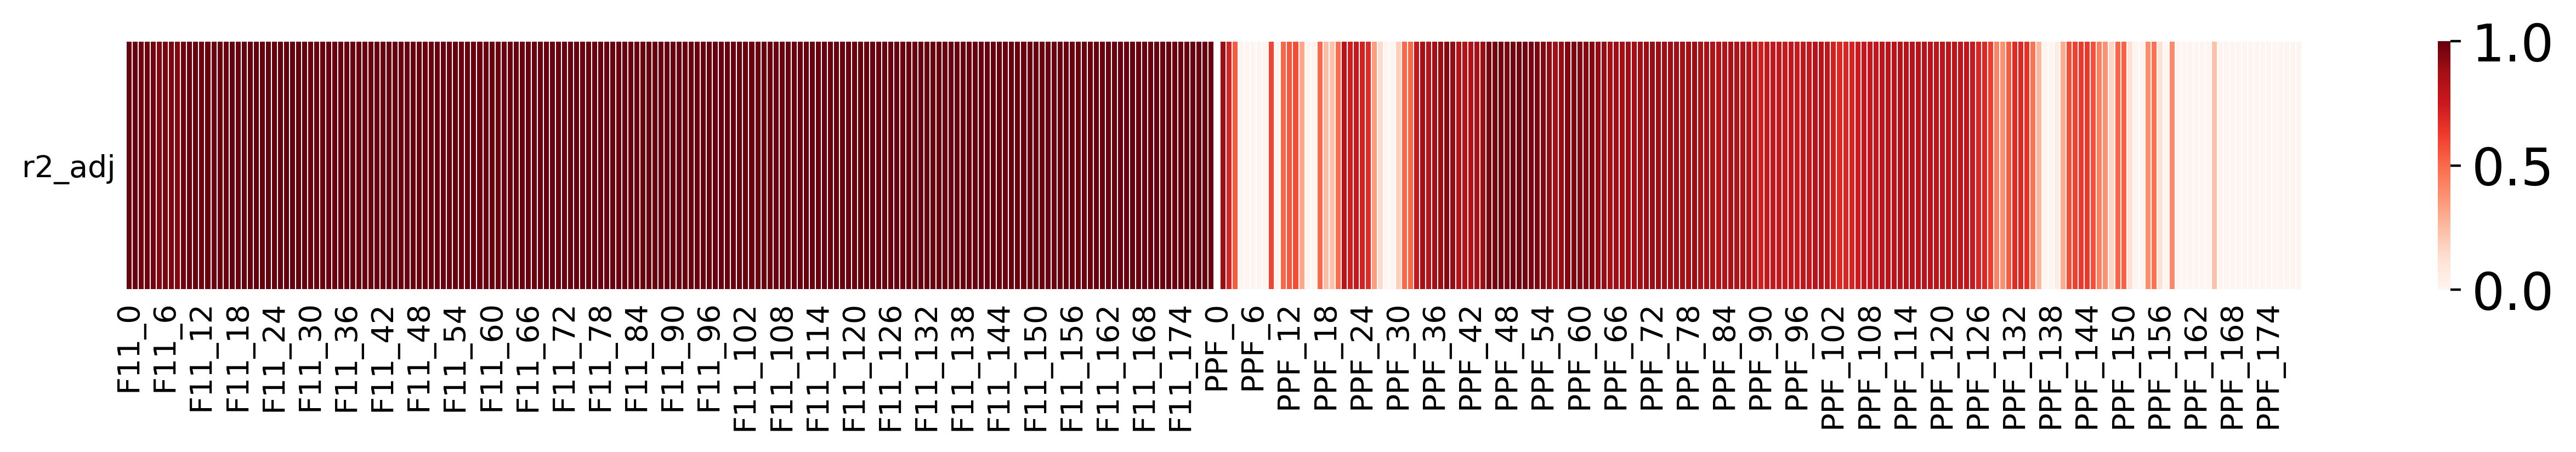

In [56]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_qoi.jpg')


## Relative Errors

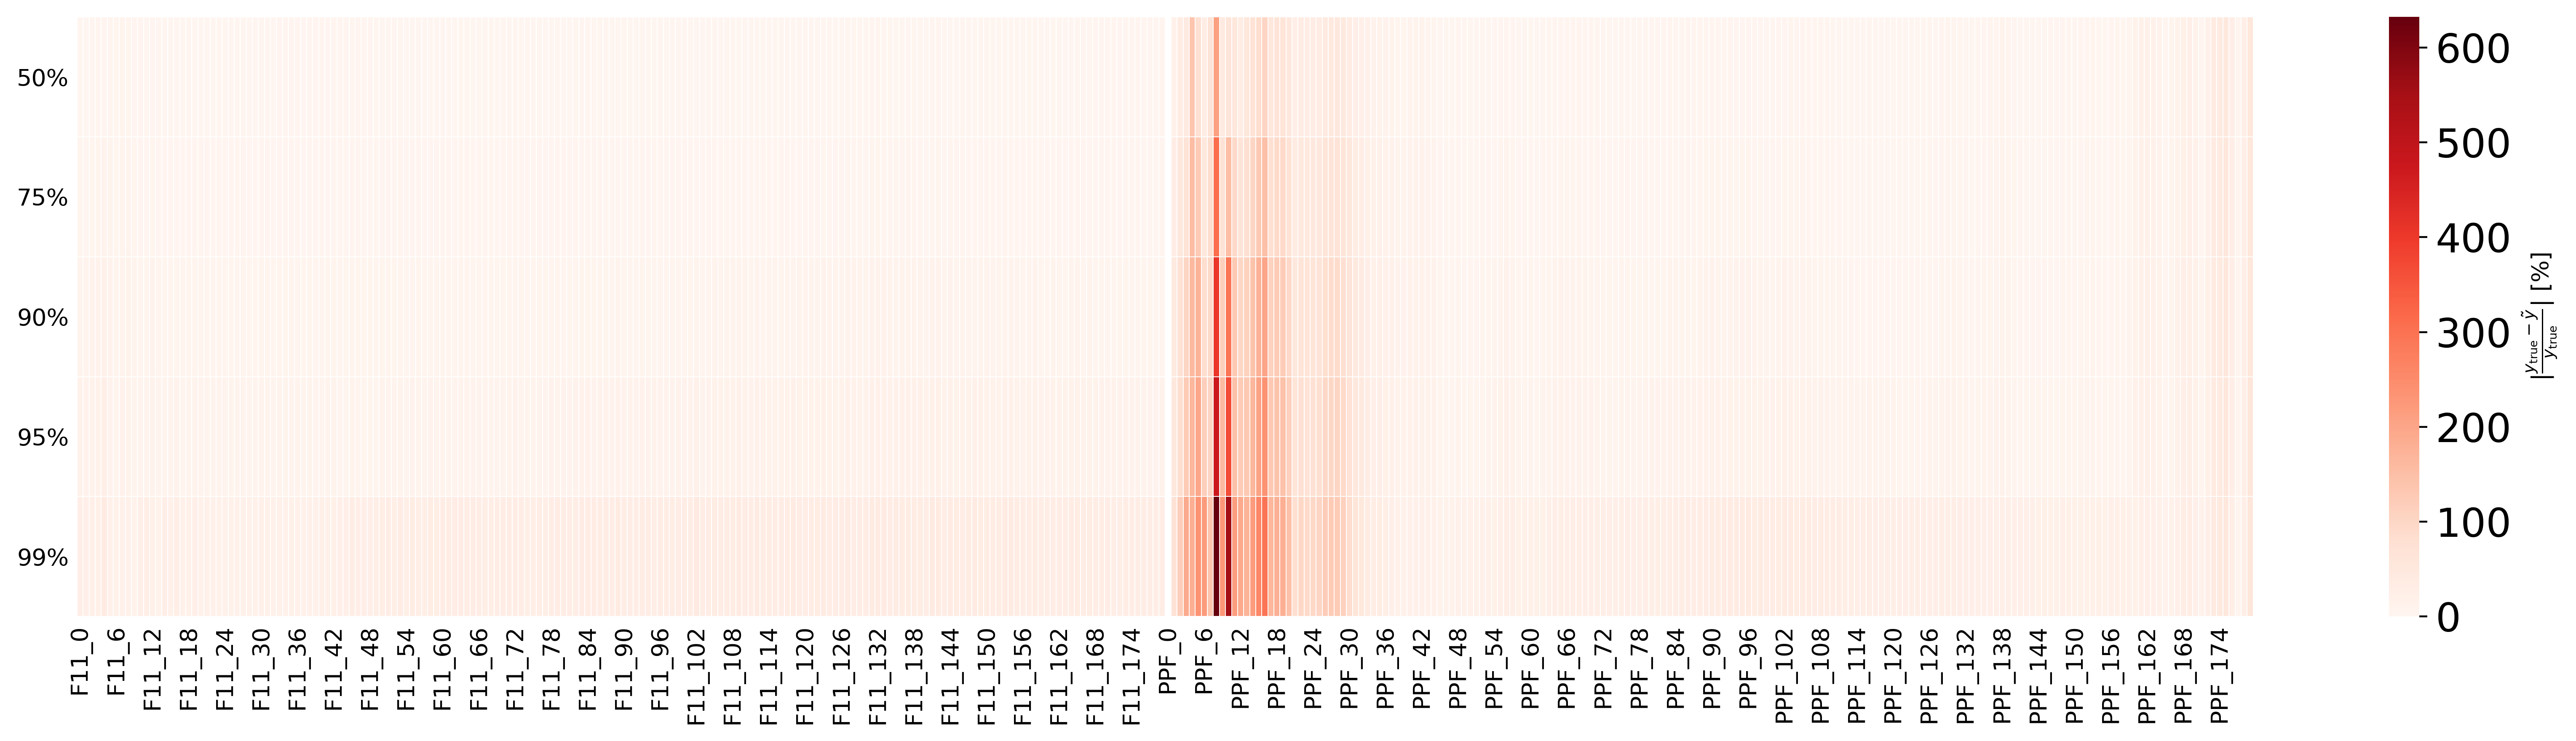

In [57]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_qoi.jpg')

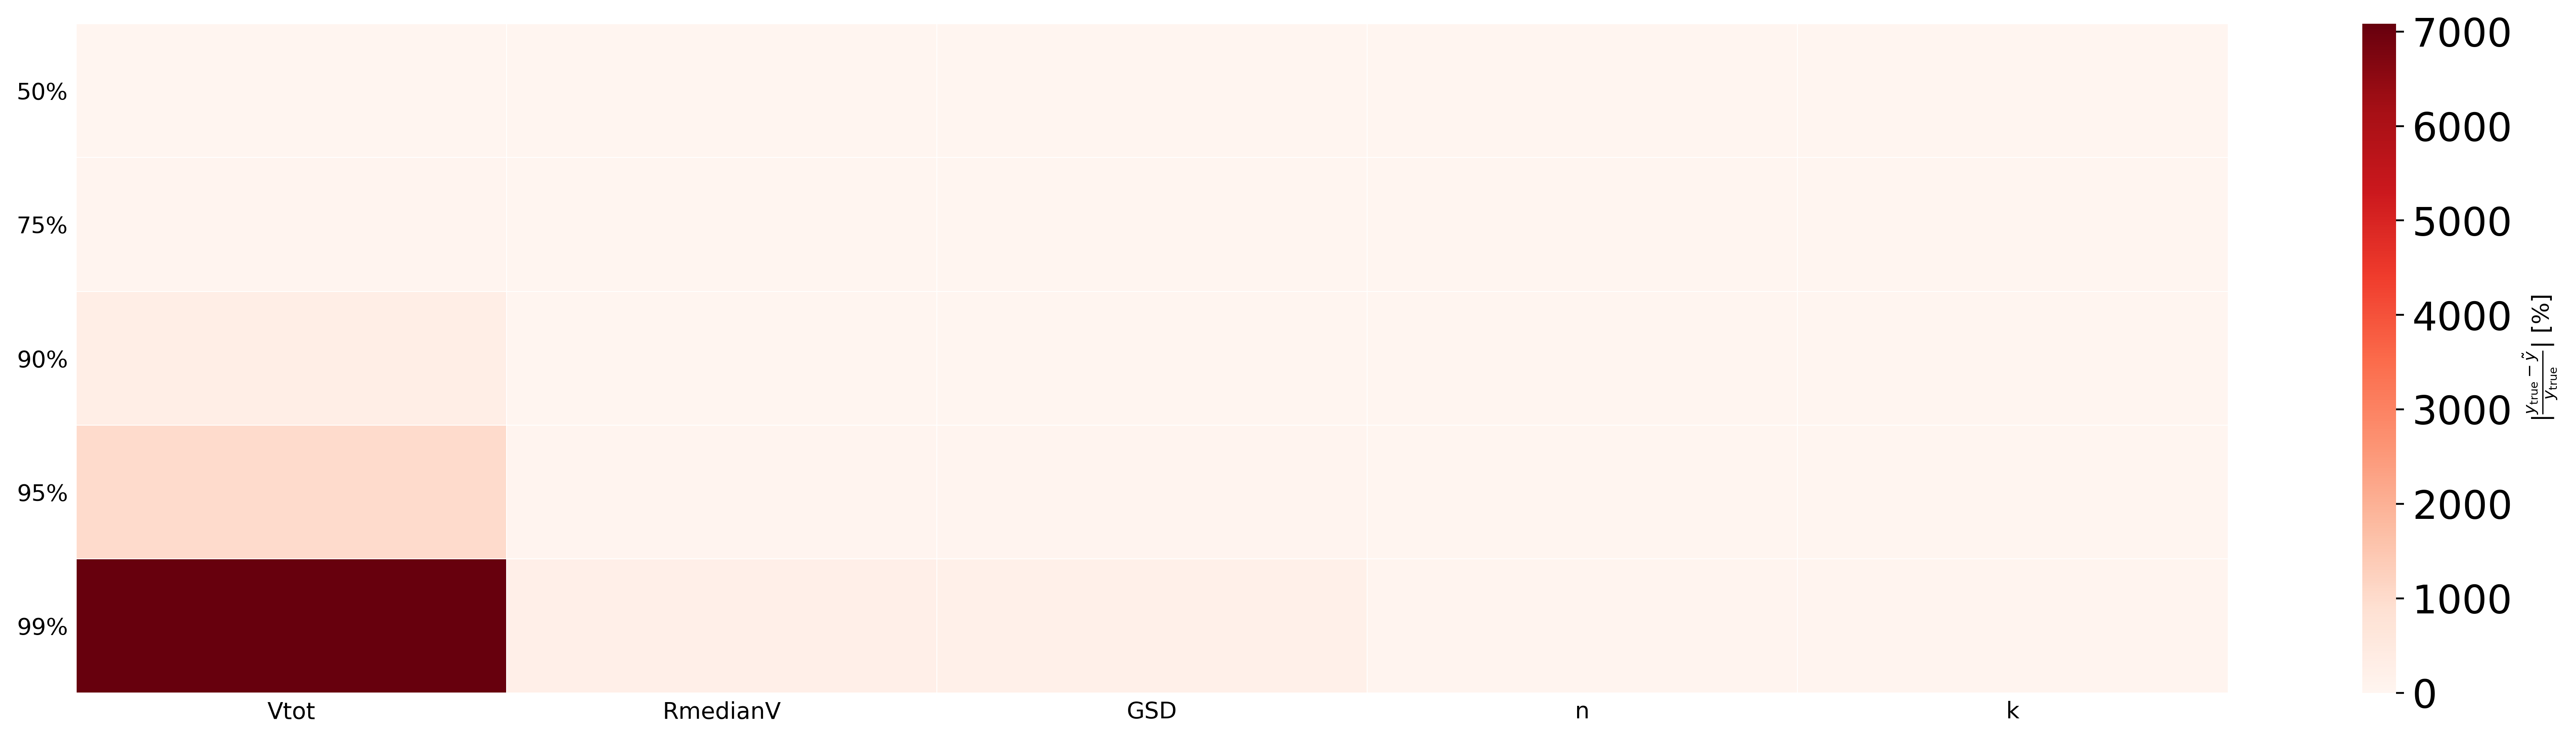

In [58]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_dvar1,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_dvar1.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_dvar1.jpg')

## Correlations between DVARs and QOIs

In [59]:
combined = pd.concat([dvar_test, rel_error_qoi], axis=1)

In [60]:
corr = np.round(combined.corr(), decimals=2)

In [61]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [62]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [63]:
to_plot

F11_0  F11_1  F11_2  F11_3  F11_4  F11_5  F11_6  F11_7  F11_8  \
Vtot      -0.19  -0.22  -0.27  -0.25  -0.18  -0.19   0.02  -0.08  -0.17   
RmedianV   0.01  -0.02  -0.17  -0.13   0.10   0.00   0.03   0.03   0.04   
GSD       -0.04  -0.02  -0.03   0.00  -0.05  -0.05  -0.05  -0.08  -0.05   
n         -0.03  -0.01   0.03   0.00  -0.00   0.01   0.00   0.01  -0.01   
k         -0.06  -0.02   0.24   0.15  -0.03   0.06   0.01   0.03   0.01   

          F11_9  ...  PPF_170  PPF_171  PPF_172  PPF_173  PPF_174  PPF_175  \
Vtot      -0.15  ...     0.01    -0.01    -0.03    -0.04     0.07    -0.05   
RmedianV  -0.05  ...     0.03    -0.00    -0.02     0.08     0.12     0.16   
GSD       -0.06  ...    -0.02    -0.02    -0.04    -0.09    -0.12     0.23   
n         -0.03  ...    -0.04    -0.02    -0.05    -0.06    -0.09    -0.15   
k         -0.01  ...    -0.03    -0.04    -0.13     0.01     0.08     0.09   

          PPF_176  PPF_177  PPF_178  PPF_179  
Vtot        -0.00    -0.03     0.01     0.04  
RmedianV     0.01     0.00     0.02     0.02  
GSD         -0.01     0.00    -0.01    -0.02  
n           -0.01     0.00    -0.02     0.02  
k           -0.02    -0.02    -0.02     0.03  

[5 rows x 360 columns]

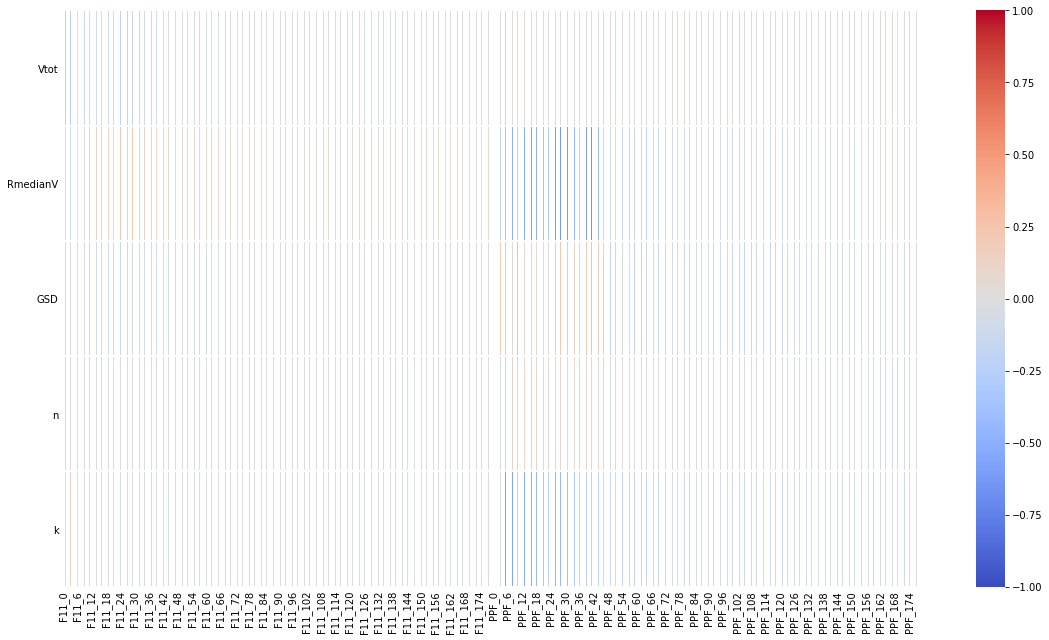

In [64]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [65]:
error_qoi = qoi_test - qoi_pred_test
error_qoi

F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      0.020984  0.020838  0.036892  0.028791 -0.022333  0.040745  0.024092   
1      0.018921  0.020779  0.026647  0.026158 -0.028283  0.050374  0.030217   
2      0.015953  0.019852  0.033014  0.029775 -0.025290  0.040170  0.018787   
3     -0.011472 -0.007697  0.018656  0.012410 -0.025915  0.040012  0.030168   
4      0.014198  0.013464  0.032320  0.028600 -0.012245  0.045070  0.037603   
...         ...       ...       ...       ...       ...       ...       ...   
17995 -0.020167 -0.017068  0.002056  0.018213  0.015451  0.043396  0.055322   
17996  0.011583  0.011526  0.025188  0.023966 -0.035961  0.047061  0.026812   
17997  0.023134  0.025950  0.048061  0.037428 -0.016552  0.049236  0.029717   
17998 -0.009140  0.002139  0.025366  0.032551  0.019418  0.055939  0.067100   
17999 -0.010993 -0.000581  0.011673  0.014843 -0.019502  0.041619  0.034122   

          F11_7     F11_8     F11_9  ...   PPF_170   PPF_171   PPF_172  \
0      0.035401  0.043498  0.028212  ... -0.062903 -0.014082  0.093592   
1      0.042296  0.055581  0.038673  ... -0.060539 -0.013556  0.095745   
2      0.028619  0.038856  0.021505  ... -0.065873 -0.019268  0.092566   
3      0.033920  0.041987  0.023604  ... -0.058102 -0.005079  0.095750   
4      0.042332  0.045051  0.030424  ... -0.062307 -0.015009  0.094209   
...         ...       ...       ...  ...       ...       ...       ...   
17995  0.044423  0.048031  0.034618  ... -0.062796 -0.011345  0.093199   
17996  0.044224  0.059910  0.042422  ... -0.052426 -0.005411  0.101093   
17997  0.041966  0.048764  0.032500  ... -0.061592 -0.012310  0.095026   
17998  0.056029  0.053694  0.039827  ... -0.064571 -0.020124  0.092701   
17999  0.039829  0.044949  0.030179  ... -0.061513 -0.018423  0.095343   

        PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  
0      0.227657  0.292149  0.384133  0.183756 -0.034078  0.155949  0.456138  
1      0.229373  0.293085  0.380577  0.184597 -0.033186  0.155918  0.457319  
2      0.225476  0.291399  0.381586  0.182519 -0.035036  0.155617  0.458091  
3      0.230036  0.295956  0.372789  0.187596 -0.032827  0.157156  0.457199  
4      0.226071  0.292335  0.386508  0.183548 -0.034620  0.155077  0.457528  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.225177  0.292303  0.376583  0.186312 -0.033583  0.156270  0.457470  
17996  0.232734  0.297557  0.381485  0.187768 -0.030340  0.158317  0.458078  
17997  0.227005  0.293725  0.382665  0.184202 -0.033025  0.156641  0.458305  
17998  0.225077  0.289338  0.382628  0.181481 -0.036727  0.153267  0.456306  
17999  0.225480  0.291196  0.384752  0.182984 -0.035156  0.155109  0.457081  

[18000 rows x 360 columns]

In [66]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns:
    sns.distplot(error_qoi[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b0096707710> (for post_execute):


KeyboardInterrupt: 

In [67]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [68]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

0
F11_0
1
F11_1
2
F11_2
3
F11_3
4
F11_4
5
F11_5
6
F11_6
7
F11_7
8
F11_8
9
F11_9
10
F11_10


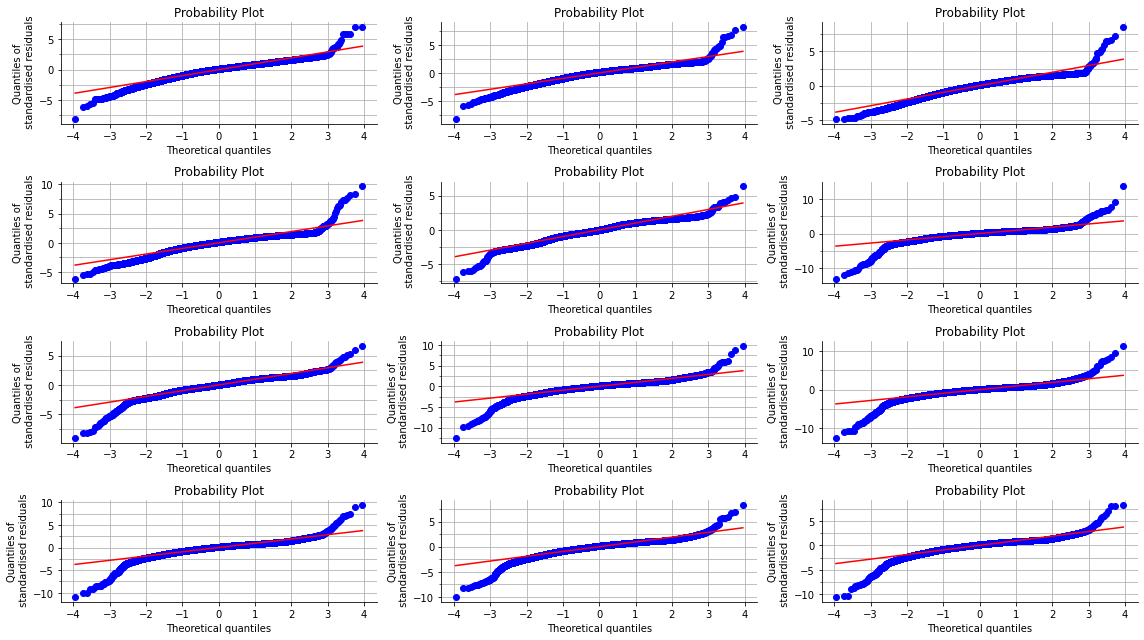

In [69]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error_qoi[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [70]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [71]:
rel_error_qoi.abs().quantile(0.9)

/psi/home/boiger_r/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


F11_0       9.233290
F11_1       8.826035
F11_2      11.188177
F11_3      10.333659
F11_4      15.976958
             ...    
PPF_175    52.230209
PPF_176    26.910175
PPF_177     5.952047
PPF_178    25.124803
PPF_179    56.761368
Name: 0.9, Length: 360, dtype: float64

In [72]:
error_qoi

F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      0.020984  0.020838  0.036892  0.028791 -0.022333  0.040745  0.024092   
1      0.018921  0.020779  0.026647  0.026158 -0.028283  0.050374  0.030217   
2      0.015953  0.019852  0.033014  0.029775 -0.025290  0.040170  0.018787   
3     -0.011472 -0.007697  0.018656  0.012410 -0.025915  0.040012  0.030168   
4      0.014198  0.013464  0.032320  0.028600 -0.012245  0.045070  0.037603   
...         ...       ...       ...       ...       ...       ...       ...   
17995 -0.020167 -0.017068  0.002056  0.018213  0.015451  0.043396  0.055322   
17996  0.011583  0.011526  0.025188  0.023966 -0.035961  0.047061  0.026812   
17997  0.023134  0.025950  0.048061  0.037428 -0.016552  0.049236  0.029717   
17998 -0.009140  0.002139  0.025366  0.032551  0.019418  0.055939  0.067100   
17999 -0.010993 -0.000581  0.011673  0.014843 -0.019502  0.041619  0.034122   

          F11_7     F11_8     F11_9  ...   PPF_170   PPF_171   PPF_172  \
0      0.035401  0.043498  0.028212  ... -0.062903 -0.014082  0.093592   
1      0.042296  0.055581  0.038673  ... -0.060539 -0.013556  0.095745   
2      0.028619  0.038856  0.021505  ... -0.065873 -0.019268  0.092566   
3      0.033920  0.041987  0.023604  ... -0.058102 -0.005079  0.095750   
4      0.042332  0.045051  0.030424  ... -0.062307 -0.015009  0.094209   
...         ...       ...       ...  ...       ...       ...       ...   
17995  0.044423  0.048031  0.034618  ... -0.062796 -0.011345  0.093199   
17996  0.044224  0.059910  0.042422  ... -0.052426 -0.005411  0.101093   
17997  0.041966  0.048764  0.032500  ... -0.061592 -0.012310  0.095026   
17998  0.056029  0.053694  0.039827  ... -0.064571 -0.020124  0.092701   
17999  0.039829  0.044949  0.030179  ... -0.061513 -0.018423  0.095343   

        PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  
0      0.227657  0.292149  0.384133  0.183756 -0.034078  0.155949  0.456138  
1      0.229373  0.293085  0.380577  0.184597 -0.033186  0.155918  0.457319  
2      0.225476  0.291399  0.381586  0.182519 -0.035036  0.155617  0.458091  
3      0.230036  0.295956  0.372789  0.187596 -0.032827  0.157156  0.457199  
4      0.226071  0.292335  0.386508  0.183548 -0.034620  0.155077  0.457528  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.225177  0.292303  0.376583  0.186312 -0.033583  0.156270  0.457470  
17996  0.232734  0.297557  0.381485  0.187768 -0.030340  0.158317  0.458078  
17997  0.227005  0.293725  0.382665  0.184202 -0.033025  0.156641  0.458305  
17998  0.225077  0.289338  0.382628  0.181481 -0.036727  0.153267  0.456306  
17999  0.225480  0.291196  0.384752  0.182984 -0.035156  0.155109  0.457081  

[18000 rows x 360 columns]

In [75]:
statistic, p = scipy.stats.shapiro(standardise(error_qoi['F11_6']).values)

/psi/home/boiger_r/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [76]:
p

0.0

In [77]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 360)               262080    
_________________________________________________________________
sequential_1 (Sequential)    (None, 5)                 261725    
Total params: 523,805
Trainable params: 523,805
Non-trainable params: 0
_________________________________________________________________


In [78]:

presentation_plot_index = [0,1,3,4,5,6,7,8,9]

qoi_test.index.values

array([    0,     1,     2, ..., 17997, 17998, 17999])

In [85]:
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

No handles with labels found to put in legend.


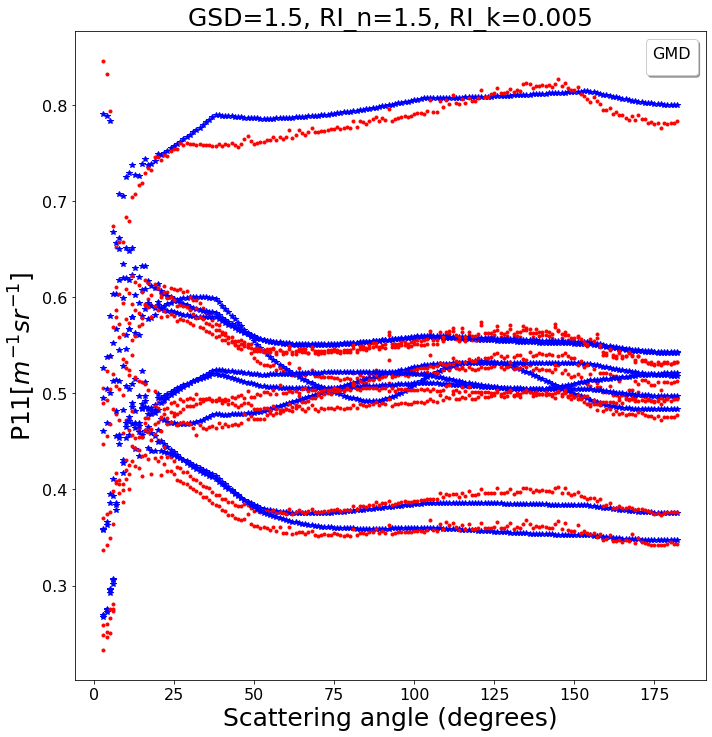

In [84]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(3,len(F11_columns)+3),qoi_test[F11_columns].iloc[index],'b*')
    ax.plot(np.arange(3,len(F11_columns)+3),qoi_pred_test[F11_columns].iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

No handles with labels found to put in legend.


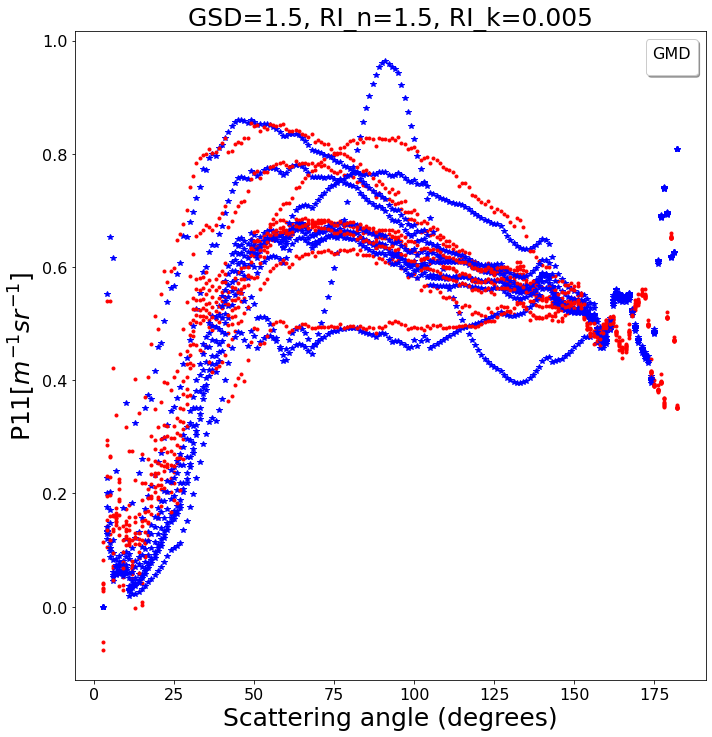

In [86]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(3,len(PPF_columns)+3),qoi_test[PPF_columns].iloc[index],'b*')
    ax.plot(np.arange(3,len(PPF_columns)+3),qoi_pred_test[PPF_columns].iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [ ]:
qoi_test

In [ ]:
qoi_pred_test

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([0, 0], [1, 1])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [ ]:
model_dir

In [ ]:
history_file = model_dir+'/history_loss.csv'
history = pd.read_csv(history_file)
history


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
ax.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
ax.set_xlabel('Epoch',fontsize = 25)
ax.set_ylabel('Loss',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

fig.savefig(f'{plot_dir}/Loss_over_epoch.jpg')


In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(autoencoder.encoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
plot_model(autoencoder.decoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([0, 0], [1,1])

plt.subplot2grid((7,3), (6,2), colspan=1, rowspan=1)

plt.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
plt.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
plt.xlabel('Epoch',fontsize = 25)
plt.ylabel('Loss',fontsize = 25)
plt.tick_params(labelsize = 16)    


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_autoencoder_model.jpg')
